In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
import datetime

sns.set_style('whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
TRAIN_DATA_PATH = '../input/train.csv'
TEST_DATA_PATH = '../input/test.csv'

origin_train = pd.read_csv(TRAIN_DATA_PATH)
origin_test = pd.read_csv(TEST_DATA_PATH)

In [48]:
def get_new_feature(file_name):
    """
    targetとの相関が高い新しい特徴量を作成する
    """
    
    #相関0.０７以上
    border= 0.07
    
    best_corr_var = pd.read_csv(file_name).rename(columns={"Unnamed: 0":"ID_code", "0":"corr"})
    #相関で並び替え→上位を取得
    var_name_li = best_corr_var.sort_values("corr", ascending=False)[best_corr_var["corr"]>border]["ID_code"]
    id_code_li = []
    for var_name in var_name_li.values:
        id_code_li.append(var_name.replace("var_", "").split("_"))
    
    #新しい特徴量の作成
    new_train = pd.DataFrame([])
    new_test = pd.DataFrame([])
    for id_code_pair in id_code_li:
        var1 = f"var_{id_code_pair[0]}"
        var2 = f"var_{id_code_pair[1]}"
        new_train_feature = origin_train[var1] / origin_train[var2]
        new_test_feature = origin_test[var1] / origin_test[var2]
        
        new_train = pd.concat([new_train, new_train_feature], axis=1)
        new_test = pd.concat([new_test, new_test_feature], axis=1)
        
        
    #相関0.０7以下（負の相関）
    border2= -0.07
    
    best_corr_var = pd.read_csv(file_name).rename(columns={"Unnamed: 0":"ID_code", "0":"corr"})
    #相関で並び替え→下位を取得
    var_name_li2 = best_corr_var.sort_values("corr", ascending=False)[best_corr_var["corr"]<border2]["ID_code"]
    id_code_li = []
    for var_name in var_name_li2.values:
        id_code_li.append(var_name.replace("var_", "").split("_"))
    
    #新しい特徴量の作成
    new_train2 = pd.DataFrame([])
    new_test2 = pd.DataFrame([])
    for id_code_pair in id_code_li:
        var1 = f"var_{id_code_pair[0]}"
        var2 = f"var_{id_code_pair[1]}"
        new_train_feature = origin_train[var1] / origin_train[var2]
        new_test_feature = origin_test[var1] / origin_test[var2]
        
        new_train2 = pd.concat([new_train2, new_train_feature], axis=1)
        new_test2 = pd.concat([new_test2, new_test_feature], axis=1)
    
    new_train = pd.concat([new_train, new_train2], axis =1)
    new_test = pd.concat([new_test, new_test2], axis =1)
    var_name_li = pd.concat([var_name_li, var_name_li2], axis =0)

    return new_train, new_test, var_name_li

In [49]:
# ADD = "../output/add_best_corr_var.csv"
# SUB = "../output/sub_best_corr_var.csv"
# MUL = "../output/multi_best_corr_var.csv"
DIV = "../output/div_best_corr_var.csv"

# add_train, add_test, add_name_li = get_new_feature(ADD)
# sub_train, sub_test, sub_name_li = get_new_feature(SUB)
# mul_train, mul_test, mul_name_li = get_new_feature(MUL)
div_train, div_test, div_name_li = get_new_feature(DIV)

/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [51]:
new_train = div_train 
new_test =  div_test
var_name_li = div_name_li

In [52]:
new_train.columns = var_name_li.values
new_test.columns = var_name_li.values

In [53]:
train = pd.concat([origin_train, new_train], axis=1).drop("ID_code", axis=1).drop("target", axis=1)
test = pd.concat([origin_test, new_test], axis=1).drop("ID_code", axis=1)

In [54]:
features = train.columns

In [58]:
target = pd.concat([origin_train, new_train], axis=1)["target"]
positive_count_train = target.sum()

rus = RandomUnderSampler(ratio={0:positive_count_train*4, 1:positive_count_train}, random_state=0)
train, target = rus.fit_sample(train, target)
train = pd.DataFrame(train, columns=features)
target = pd.DataFrame(target)

(200000,)


In [10]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask= y>0
        mask.reshape
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [59]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': 2,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [60]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    #argument
#     trn_train, trn_target= augment(np.array(train.iloc[trn_idx]), np.array(np.array(target.iloc[trn_idx])))
#     trn_data = lgb.Dataset(trn_train, label=trn_target)
#     val_train, val_target= augment(np.array(train.iloc[val_idx]), np.array(target.iloc[val_idx]))
#     val_data = lgb.Dataset(val_train, label=val_target)

    #not argument
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])
    
    num_round = 30000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.825893	valid_1's auc: 0.815081
[2000]	training's auc: 0.860739	valid_1's auc: 0.849881
[3000]	training's auc: 0.877522	valid_1's auc: 0.86578
[4000]	training's auc: 0.88802	valid_1's auc: 0.875808
[5000]	training's auc: 0.89532	valid_1's auc: 0.882158
[6000]	training's auc: 0.900905	valid_1's auc: 0.886597
[7000]	training's auc: 0.905138	valid_1's auc: 0.889511
[8000]	training's auc: 0.908511	valid_1's auc: 0.892022
[9000]	training's auc: 0.911293	valid_1's auc: 0.893869
[10000]	training's auc: 0.913666	valid_1's auc: 0.89511
[11000]	training's auc: 0.915703	valid_1's auc: 0.895967
[12000]	training's auc: 0.917383	valid_1's auc: 0.896719
[13000]	training's auc: 0.91893	valid_1's auc: 0.897435
[14000]	training's auc: 0.92037	valid_1's auc: 0.897855
[15000]	training's auc: 0.921773	valid_1's auc: 0.898185
[16000]	training's auc: 0.923035	valid_1's auc: 0.898647
[17000]	training's auc: 0.924275

[5000]	training's auc: 0.896084	valid_1's auc: 0.877219
[6000]	training's auc: 0.901404	valid_1's auc: 0.881863
[7000]	training's auc: 0.905443	valid_1's auc: 0.885167
[8000]	training's auc: 0.908801	valid_1's auc: 0.887671
[9000]	training's auc: 0.911532	valid_1's auc: 0.889702
[10000]	training's auc: 0.913842	valid_1's auc: 0.891287
[11000]	training's auc: 0.915794	valid_1's auc: 0.892532
[12000]	training's auc: 0.917448	valid_1's auc: 0.893679
[13000]	training's auc: 0.919062	valid_1's auc: 0.894607
[14000]	training's auc: 0.920485	valid_1's auc: 0.895259
[15000]	training's auc: 0.921889	valid_1's auc: 0.895813
[16000]	training's auc: 0.923141	valid_1's auc: 0.896255
[17000]	training's auc: 0.924428	valid_1's auc: 0.896578
[18000]	training's auc: 0.925571	valid_1's auc: 0.896824
[19000]	training's auc: 0.926675	valid_1's auc: 0.8969
[20000]	training's auc: 0.927767	valid_1's auc: 0.897082
[21000]	training's auc: 0.928845	valid_1's auc: 0.897171
[22000]	training's auc: 0.929877	valid

/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


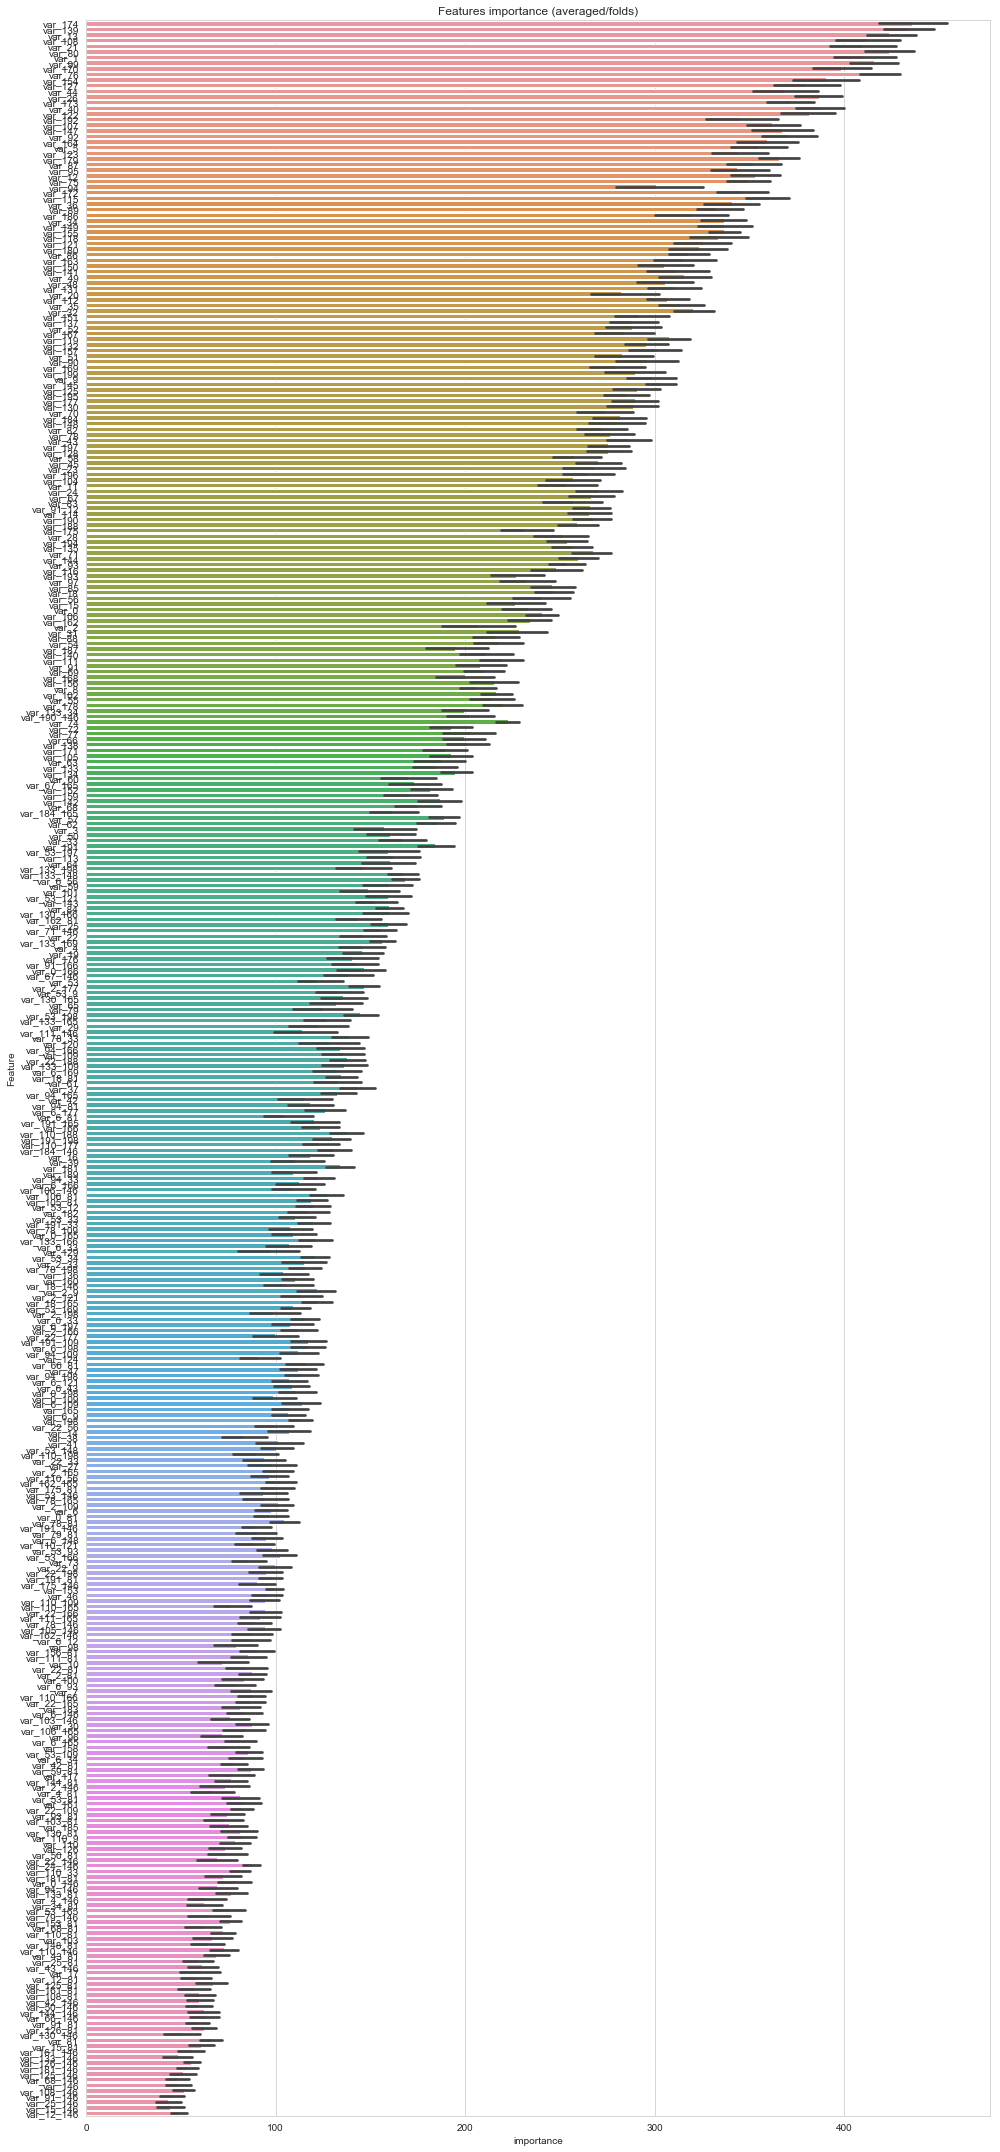

In [67]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:6000].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,30))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [61]:
feature_importance.to_csv(f"../output/importamce_div_under_{roc_auc_score(target, oof)}.csv", index=False)

In [62]:
score = round(roc_auc_score(target, oof), 4)
sub = pd.DataFrame({"ID_code": origin_test["ID_code"]})
sub["target"]=predictions
sub.to_csv(f"../output/submission_new_div_under_{score}.csv", index=False)

In [64]:
train.to_csv(f"../output/new_feature_div_under_train.csv", index=False)
test.to_csv(f"../output/new_feature_div_under_test.csv", index=False)

In [65]:
origin_test["ID_code"]

0              test_0
1              test_1
2              test_2
3              test_3
4              test_4
5              test_5
6              test_6
7              test_7
8              test_8
9              test_9
10            test_10
11            test_11
12            test_12
13            test_13
14            test_14
15            test_15
16            test_16
17            test_17
18            test_18
19            test_19
20            test_20
21            test_21
22            test_22
23            test_23
24            test_24
25            test_25
26            test_26
27            test_27
28            test_28
29            test_29
30            test_30
31            test_31
32            test_32
33            test_33
34            test_34
35            test_35
36            test_36
37            test_37
38            test_38
39            test_39
40            test_40
41            test_41
42            test_42
43            test_43
44            test_44
45        